# Kriging and IDW
## Libraries in R
- gstat
- geoR
- spatstat

### gstat
- data format: gstat object
- functions:
 - `variogram()`
 - `vgm()`
 - `krige()`
- also IDW
- also Space time kriging

### geoR  (specifically for kriging)
- data format: geodata object
- functions:
  - `variog()`
  - `variofit()`
  - `krige,conv()`

### spatstat  (most extensive)
- data format: ppp
- functions:
    - kernel density, Ripley's K, IDW 

In [21]:
library('dplyr')
library('spdep')
library('spatstat')
library('geoR')
#library('gstat')
library('raster')
library('RColorBrewer')

setwd(paste0('/home/micha/Studies/Courses',
             '/Geostatistics-Tal/Project/'))
date_str <- '20170112'
data_file <- paste0('gauge_data/','gauge_data_daily.csv')
data_cols <- c('station_id','date_time','quality',
                 'obs_precip', 'precip_ind','snow','eor')

gauge_data <- read.csv(data_file, col.names=data_cols)
# Boundary data for States
gadm_1 <- readRDS('GIS/DEU_adm1.rds')

In [22]:
meta_cols <- c('station_id','from_date','to_date','elevation',
               'latitude','longitude',
               'stn_name','province')
gauge_metadata <- read.csv('gauge_data/gauge_metadata.csv', col.names=meta_cols)
# Get one day (or hour), and attach metadata
gauge_data_filtered <- filter(gauge_data, date_time==date_str)
gauges <- merge(gauge_data_filtered, gauge_metadata, by='station_id', all.y=TRUE)
# Make sure to clean out NA or < 0 (unknown values)
gauges <- na.omit(gauges)
gauges <- filter(gauges, obs_precip>=0)

## IDW Interpolation

In [23]:
# Convert data to ppp
gauges_owin <- ripras(gauges$longitude, gauges$latitude,
                      shape="rectangle")
gauges_marks <- gauges$obs_precip
gauges_ppp <- ppp(gauges$longitude, gauges$latitude, 
                  window=gauges_owin,
                  marks=gauges_marks)
# Setup matrix of coordinates for later (RMSE calculations)
coord_matrix <- cbind(gauges$longitude,
                      gauges$latitude) 
# Set dimensions
minx <- min(gauges$longitude)
maxx <- max(gauges$longitude)
miny <- min(gauges$latitude)
maxy <- max(gauges$latitude)
nsdim <- ceiling((maxy - miny)/0.01)
ewdim <- ceiling((maxx - minx)/0.01)
# Run IDW
gauges_idw <- idw(gauges_ppp, dimyx=c(nsdim, ewdim))

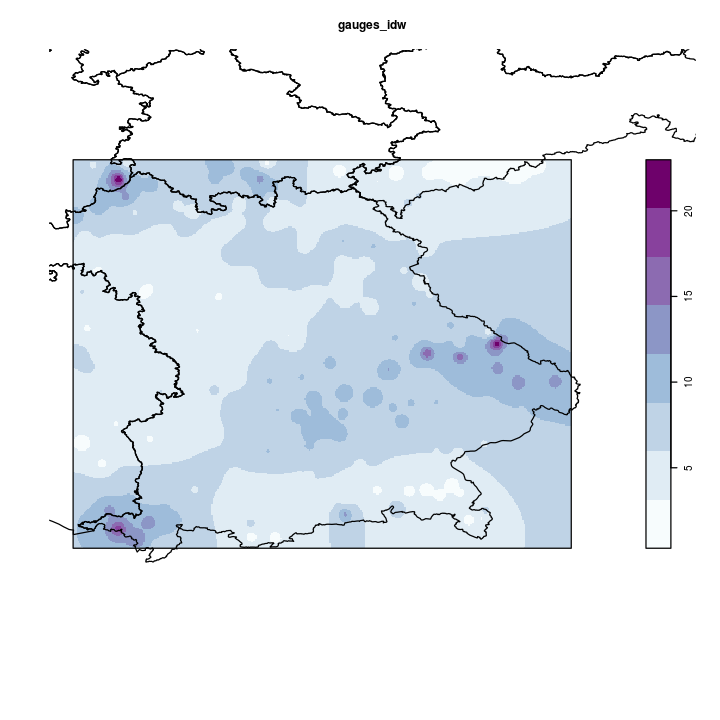

In [24]:
options(repr.plot.width=6, repr.plot.height=6)
clrs <- brewer.pal(8,'BuPu')
opar <- par(pch=4, col="grey30", cex=0.5, lwd=1)
plot(gauges_idw, col=clrs)
plot(gadm_1, border='black', add=T)
points(gauges, col="red")

### IDW - predicted precipitation
![IDW](gauges_idw.png)

### Check RMSE for IDW interpolation

In [25]:
# Extract IDW values at original points for comparison
gauges_idw_pts <- extract(raster(gauges_idw), coord_matrix)
# and calculate RMSE from original locations
rmse_idw <- sqrt(mean((gauges_ppp$marks - gauges_idw_pts)^2))
print(rmse_idw)

[1] 0.01581958


## Variogram

In [26]:
# Variogram and Envelope
vg <- variog(coords=coord_matrix, 
             data=gauges$obs_precip, max.dist=3)
# Run 9999 Monte Carlo simulations
vg_envel <- variog.mc.env(coords=coord_matrix, 
                          data=gauges$obs_precip, 
                          obj.var=vg, nsim=999)

variog: computing omnidirectional variogram
variog.env: generating 999 simulations by permutating data values
variog.env: computing the empirical variogram for the 999 simulations
variog.env: computing the envelops


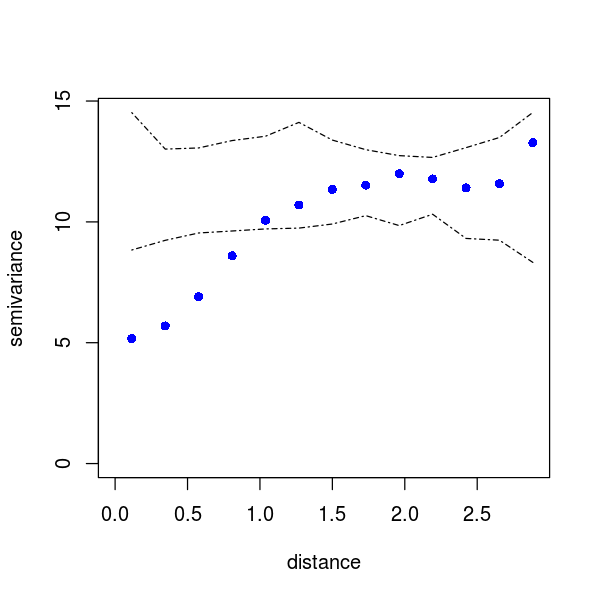

In [27]:
options(repr.plot.width=5, repr.plot.height=5)
plot(vg, envelope=vg_envel, pch=16, col="blue")

### Fit variogram model

In [28]:
# Guess at sill and range
krige_params = c(11, 1.5)
# Use three different models
vg_fit_exp <- variofit(vg, ini.cov.pars=krige_params, 
                       cov.model = "exponential",
                       fix.nugget = F, nugget = 3)
vg_fit_sph <- variofit(vg, ini.cov.pars=krige_params, 
                       cov.model = "spherical",
                       fix.nugget = F, nugget = 3)
vg_fit_gau <- variofit(vg, ini.cov.pars=krige_params, 
                       cov.model = "gaussian",
                       fix.nugget = F, nugget = 3)

variofit: covariance model used is exponential 
variofit: weights used: npairs 
variofit: minimisation function used: optim 
variofit: covariance model used is spherical 
variofit: weights used: npairs 
variofit: minimisation function used: optim 
variofit: covariance model used is gaussian 
variofit: weights used: npairs 
variofit: minimisation function used: optim 


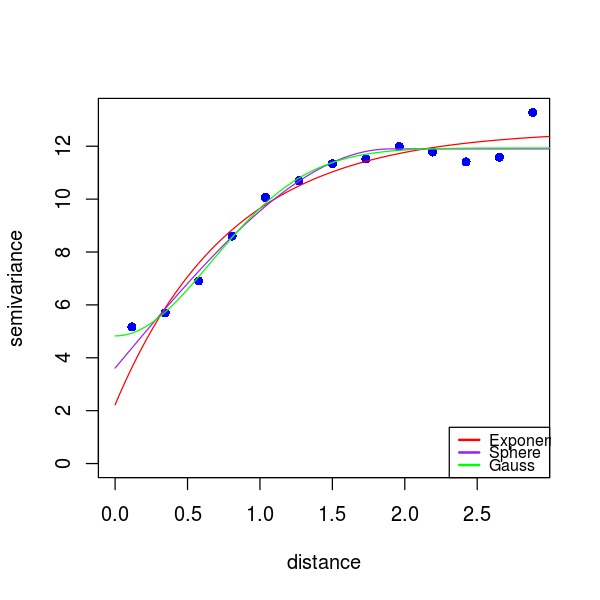

In [29]:
plot(vg, pch=16, col="blue")
lines.variomodel(vg_fit_exp, col="red")
lines.variomodel(vg_fit_sph, col="purple")
lines.variomodel(vg_fit_gau, col="green")
lclrs <- c('red','purple','green')
lgnd <- c('Exponential','Sphere','Gauss')
legend('bottomright', 
       col=lclrs, legend=lgnd, lwd=2, cex=0.8)

### Kriging - Predicted precipitation

krige.conv: model with constant mean
krige.conv: Kriging performed using global neighbourhood 


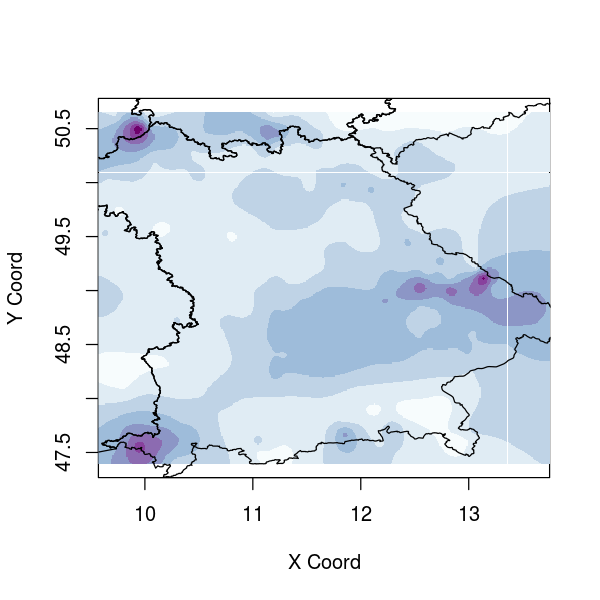

In [30]:
grd <- expand.grid(seq(minx,maxx,0.01), seq(miny,maxy,0.01))
gauges_ok <- krige.conv(coords=coord_matrix, data=gauges$obs_precip, 
                        krige = krige.control(cov.pars=krige_params), 
                        locations = grd)
image(gauges_ok, col=clrs)
plot(gadm_1, border='black', lwd=1, add=T)

### Check RMSE for Kriging

In [31]:
# Create raster object from krige predictions
gauges_ok_rast <- raster(xmn=minx, xmx=maxx, 
                         ymn=miny, ymx=maxy, 
                         nrows=nsdim, ncols=ewdim, 
                         vals=gauges_ok$predict)
gauges_ok_pts <- extract(gauges_ok_rast, coord_matrix)
# Calculate RMSE with original values
rmse_ok <- sqrt(mean((gauges$obs_precip - gauges_ok_pts)^2))
print(rmse_ok)

[1] 3.147071


### IDW shows * much lower * RMSE than kriging